In [1]:
from torch import rand
import gym
import time
from stable_baselines3 import PPO, SAC
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
# from cassie import CassieRefEnv
from model_wholebody_2 import *
import matplotlib.pyplot as plt
import random
import numpy as np
from math import floor

t = time.monotonic()
# model = PPO.load("model_saved/ppo_cassie_"+str(512 * 36)+"00")
# model = PPO.load("./wrenchflatmodel/ppo_cassie-2969600")
# model = PPO.load("standstill")

# model = SAC.load('best_model_new_SAC_balancing')
model = SAC.load('best_model_new_SAC_balancing_2')

# model = RecurrentPPO.load('models_lstm_no_action_track')
# cassie = CassieRefEnv(dynamics_randomization=False)
# env = Soft_Arm_Model("/home/fury/LIDAR/Soft-Arm-Mujoco/cassie-softarm/softarm_2_OG.xml", render=True)
env = CassieArmEnv(datafile="dataset/data1.json", render_mode='human')
# env = Soft_Arm_Model_Imitation("cassie-softarm/cassie_soft_arm_v2.xml", ik_model_path = "ik_model/modelv3.h5",  datafile = "dataset/dataset_slider1.json", render=True)
obs, _ = env.reset()


print("shape", len(obs["observation"]))
# print(len(obs))
action_arr = []
ee_pose_arr = []
targ_pose_arr = []    
# trace circle
radius = 0.3
time_factor = 0.07

start_time = time.monotonic()

datafile = "dataset/data1.json"

with open(datafile) as f:
        data = json.load(f)
        f.close()
        
df = pd.json_normalize(data['data'])
X = df.drop('actions', axis=1)
y = pd.DataFrame(df['actions'].to_list())  # Assuming 'actions' is a list
ee_position = pd.DataFrame(X['end-effector-position'].tolist(), columns=['ee_pos_x', 'ee_pos_y', 'ee_pos_z'])
# ee_position = ee_position[['ee_pos_z', 'ee_pos_y', 'ee_pos_x']]
X = pd.concat([X.drop('end-effector-position', axis=1), ee_position], axis=1)
ee_orientation = pd.DataFrame(X['end-effector-orientation'].tolist(), columns=['ee_ori_w', 'ee_ori_x', 'ee_ori_y', 'ee_ori_z'])
X = pd.concat([X.drop('end-effector-orientation', axis=1), ee_orientation], axis=1)

# make different datadrame for ee position and orientation
X_ee = X[['ee_pos_x', 'ee_pos_y', 'ee_pos_z', 'ee_ori_w', 'ee_ori_x', 'ee_ori_y', 'ee_ori_z']]

# sample from the dataset
sample = X_ee.sample()
sample = sample.to_numpy()[0]
# print("sample", sample.to_numpy())



    # if floor(t) % 10 == 0:
    #     #save data in numpy array
    #     # action_arr = np.array(action_arr)
    #     # ee_pose_arr = np.array(ee_pose_arr)
    #     # targ_pose_arr = np.array(targ_pose_arr)
    #     # np.save('action_arr.npy', action_arr)
    #     # np.save('ee_pose_arr.npy', ee_pose_arr)
    #     # np.save('targ_pose_arr.npy', targ_pose_arr)
    #     sample = X_ee.sample()
    #     sample = sample.to_numpy()[0]

    #     env.reset(target_pose=sample)

    #     terminated = False
        # break

    # if terminated: #cassie.qpos[2]<0.6:
    #     # plt.plot(vel)
    #     # plt.show()
    #     # plt.legend()

    #     vel = []
    #     # cassie.setforce = 0# random.uniform(0,8)#0-8
    #     # print("yforce:",cassie.setforce)
    #     obs, _ = env.reset()

    #     # print(cassie.speed)
        



2024-04-29 19:41:52.438045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 19:41:52.438085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 19:41:52.439103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 19:41:52.444184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 19:41:53.079259: W tensorflow/compiler/tf2

shape 115


In [3]:
terminated = False
obs, _ = env.reset()

i = 0

tol = 0.01
past_ee_pos_norm = np.linalg.norm(obs["observation"][11:14])

ee_pos = []
ee_pos_diff = []
effort = []
arm_corrections = []
original_arm_effort = []
pred_arm_effort = []
while True:

    # obs, _ = env.reset()

    ob = obs["observation"]
    obs_c = obs.copy()
    

    # print("obs shape", len(ob))
    # targ_x = radius * np.cos(t*time_factor)
    # targ_y = radius * np.sin(t*time_factor)
    # targ_z = 1.7

    # sample[0] = targ_x
    # sample[1] = targ_y
    # sample[2] = targ_z
    # sample[3] = 0
    # sample[4] = -0.8509035
    # sample[5] = 0
    # sample[6] = 0.525322
    # print("sample", sample)

    
    # env.data_obs[6:] = sample
    # obs_c["observation"][19:26] = sample

    # obs = obs_c

    # print("shape", len(obs["observation"]))
    # target_pos = obs[0:3]
    # print("target_pose", sample[0:3])

    action, _states = model.predict(obs_c,deterministic=True)

    print("action", action)
    # action, _ = model.predict(obs,deterministic=True)
    obs, rewards, terminated, _, info = env.step(action)
    # print(len(cassie.sim.qpos()))
    # while time.monotonic() - t < 60*0.0005:
    #     time.sleep(0.0001)
    #     # cassie.render()
    t = time.monotonic() - start_time

    # time.sleep(0.05)
    # print("time", floor(t))
    
    # pos_index = np.array([7, 8, 9, 14, 20, 21, 22, 23, 28, 34])
    # qpos=np.array(cassie.sim.qpos())
    # joints=qpos[pos_index].tolist()
    # vel.append(joints)
    
    # vel.append(cassie.sim.qvel()[0])

    # action_arr.append(action)
    # ee_pose_arr.append(ob[9:12])
    # targ_pose_arr.append(sample.tolist())

    z = env.data.sensor("pelvis-pose").data

    print("target_pose", obs["observation"][18:21])

    i += 1
    if z[2] < 0.5 :
        env._update_init_qpos()
        obs, _ = env.reset(target_pose=sample, random=True)
        i = 0
    elif i > 1000:
        obs, _ = env.reset(target_pose=sample, random=True)
        i = 0

    curent_ee_pos_norm = np.linalg.norm(obs["observation"][11:14])
    ee_pos.append(obs["observation"][11:14])
    effort.append(action)
    ee_pos_diff.append(obs["observation"][11:14] - obs["observation"][18:21])
    arm_corrections.append(env.arm_corrections)
    original_arm_effort.append(env.action_arms)
    pred_arm_effort.append(env.arm_action_pred_online)

    if abs(curent_ee_pos_norm - past_ee_pos_norm) < tol:
        break




action [ 3.98372519  3.96826494 -8.39859163 10.13696198 -0.87235453 -4.21842733
 -4.24959514  6.20067325  6.94015956 -0.80870678 -3.00097191 -2.26561674
  2.48826674 -2.88906911 -1.98999883 -2.59510306]
target_pose [-0.00651094  0.12036161  0.38230136]
action [-1.28160346  3.36416817 -2.09810102  4.14982562 -0.20211486 -2.0905247
 -3.71876317  7.98668604  7.98302107  0.76527221 -0.66498835 -1.95079917
  2.56775584 -2.16859684 -1.77765768  2.98233551]
target_pose [-0.01819462  0.12036161  0.38230136]
action [-1.28160346  3.36416817 -2.09810102  4.14982562 -0.20211486 -2.0905247
 -3.71876317  7.98668604  7.98302107  0.76527221 -0.66498835 -1.95079917
  2.56775584 -2.16859684 -1.77765768  2.98233551]
target_pose [-0.03112199  0.12036161  0.38230136]
action [  4.30289304   3.66493821   1.90041077  12.14770727  -0.89951956
  -3.80623698  -4.21152574 -10.56398557  11.94194827  -0.23773234
  -2.94235842  -2.31599666   2.55203997  -2.80485903  -2.1416386
  -2.94187606]
target_pose [-0.04500157

KeyboardInterrupt: 

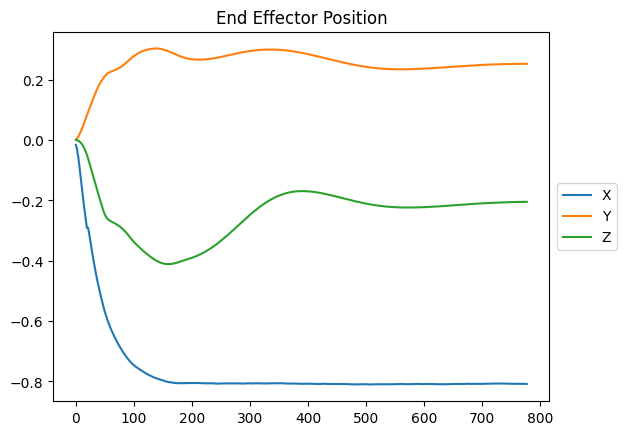

In [4]:
# plot the data
plt.plot(ee_pos)
plt.title("End Effector Position")
plt.legend(["X", "Y", "Z"], loc='right', bbox_to_anchor=(1.15, 0.5))
plt.show()

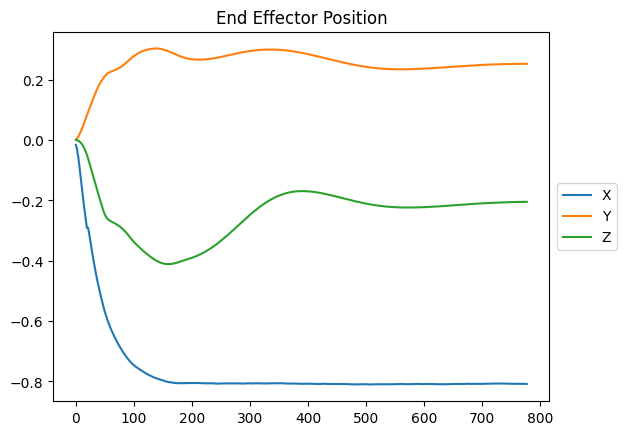

In [5]:
# plot the data
plt.plot(ee_pos)
plt.title("End Effector Position")
plt.legend(["X", "Y", "Z"], loc='right', bbox_to_anchor=(1.15, 0.5))
plt.show()

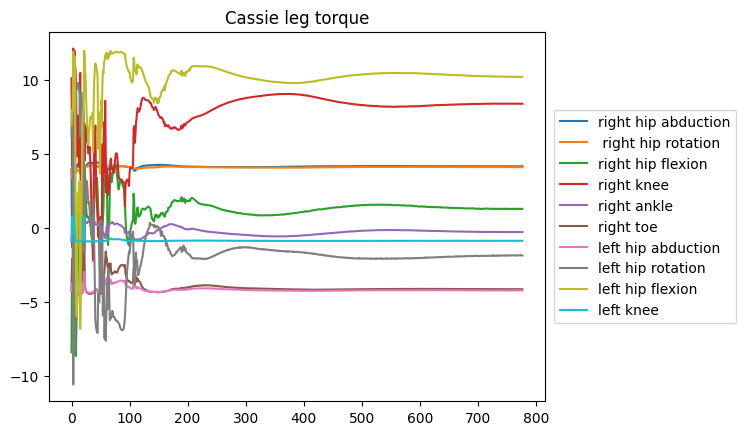

In [6]:
np.array(effort).shape
plt.plot(np.array(effort)[:,0:10])
plt.title("Cassie leg torque")
plt.legend(["right hip abduction", " right hip rotation", "right hip flexion", "right knee", "right ankle", "right toe", "left hip abduction", "left hip rotation", "left hip flexion", "left knee", "left ankle", "left toe"], loc='right', bbox_to_anchor=(1.4, 0.5))
plt.show()

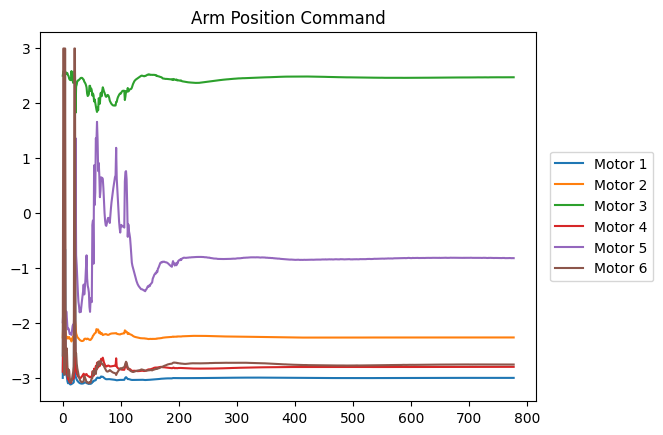

In [7]:
np.array(effort).shape
plt.plot(np.array(effort)[:,10:])
plt.title("Arm Position Command")
plt.legend(["Motor 1", "Motor 2", "Motor 3", "Motor 4", "Motor 5", "Motor 6"], loc='right', bbox_to_anchor=(1.25, 0.5))
plt.show()

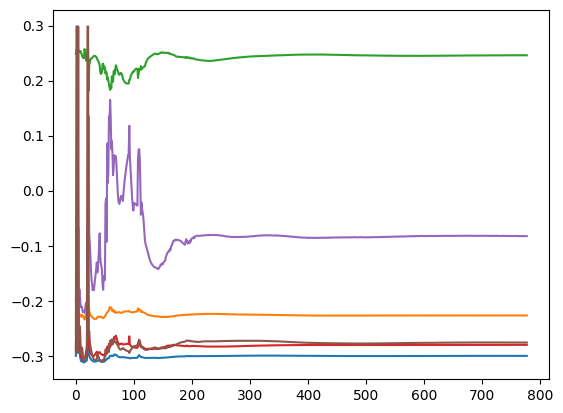

In [8]:
plt.plot(arm_corrections)
plt.show()

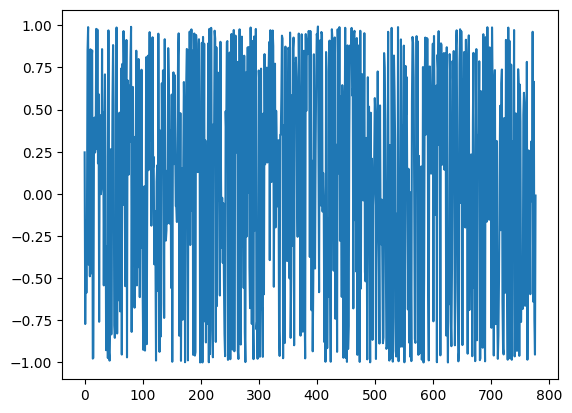

In [9]:
plt.plot(np.array(pred_arm_effort)[:,0])
plt.show()